<a href="https://colab.research.google.com/github/vinny380/bayes_network_genre_prediction/blob/main/Na%C3%AFve_Bayes_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

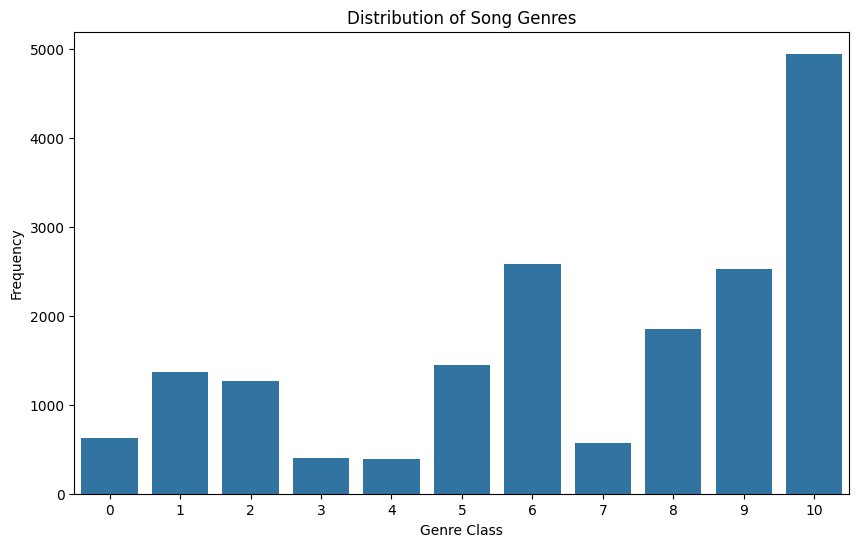

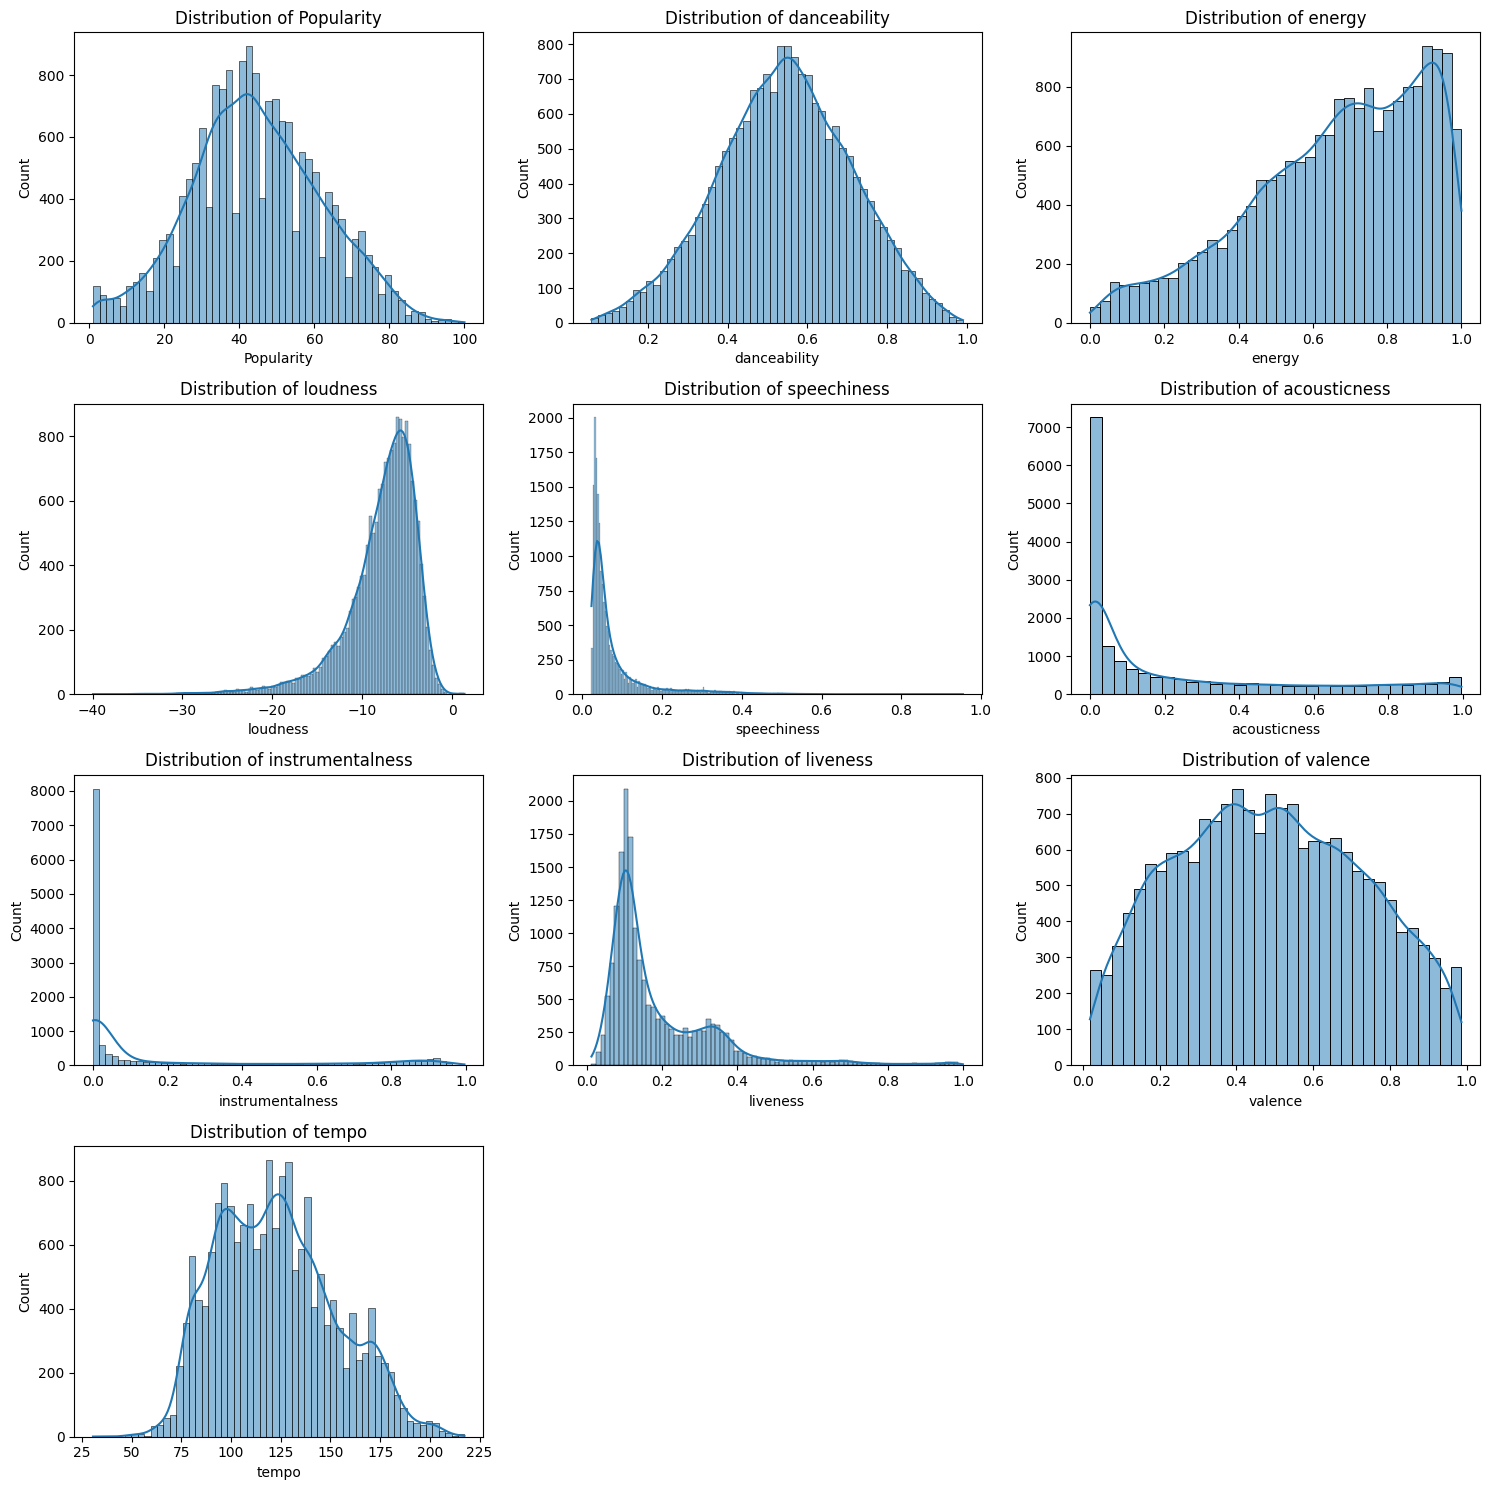

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset
train_set_path = 'https://raw.githubusercontent.com/vinny380/bayes_network_genre_prediction/main/train.csv'
df = pd.read_csv(train_set_path)

# Distribution of Target Classes
plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=df)
plt.title('Distribution of Song Genres')
plt.xlabel('Genre Class')
plt.ylabel('Frequency')
plt.show()

# Feature Distributions
features = ['Popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
plt.figure(figsize=(15, 15))
for i, feature in enumerate(features, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [6]:
# Preprocessing the dataset
data_preprocessed = df.drop(['Artist Name', 'Track Name'], axis=1)
for col in data_preprocessed.columns:
    if data_preprocessed[col].dtype == 'float64':
        data_preprocessed[col].fillna(data_preprocessed[col].median(), inplace=True)
data_preprocessed['Duration_minutes'] = data_preprocessed['duration_in min/ms'] / 60000
data_preprocessed.drop(['duration_in min/ms'], axis=1, inplace=True)

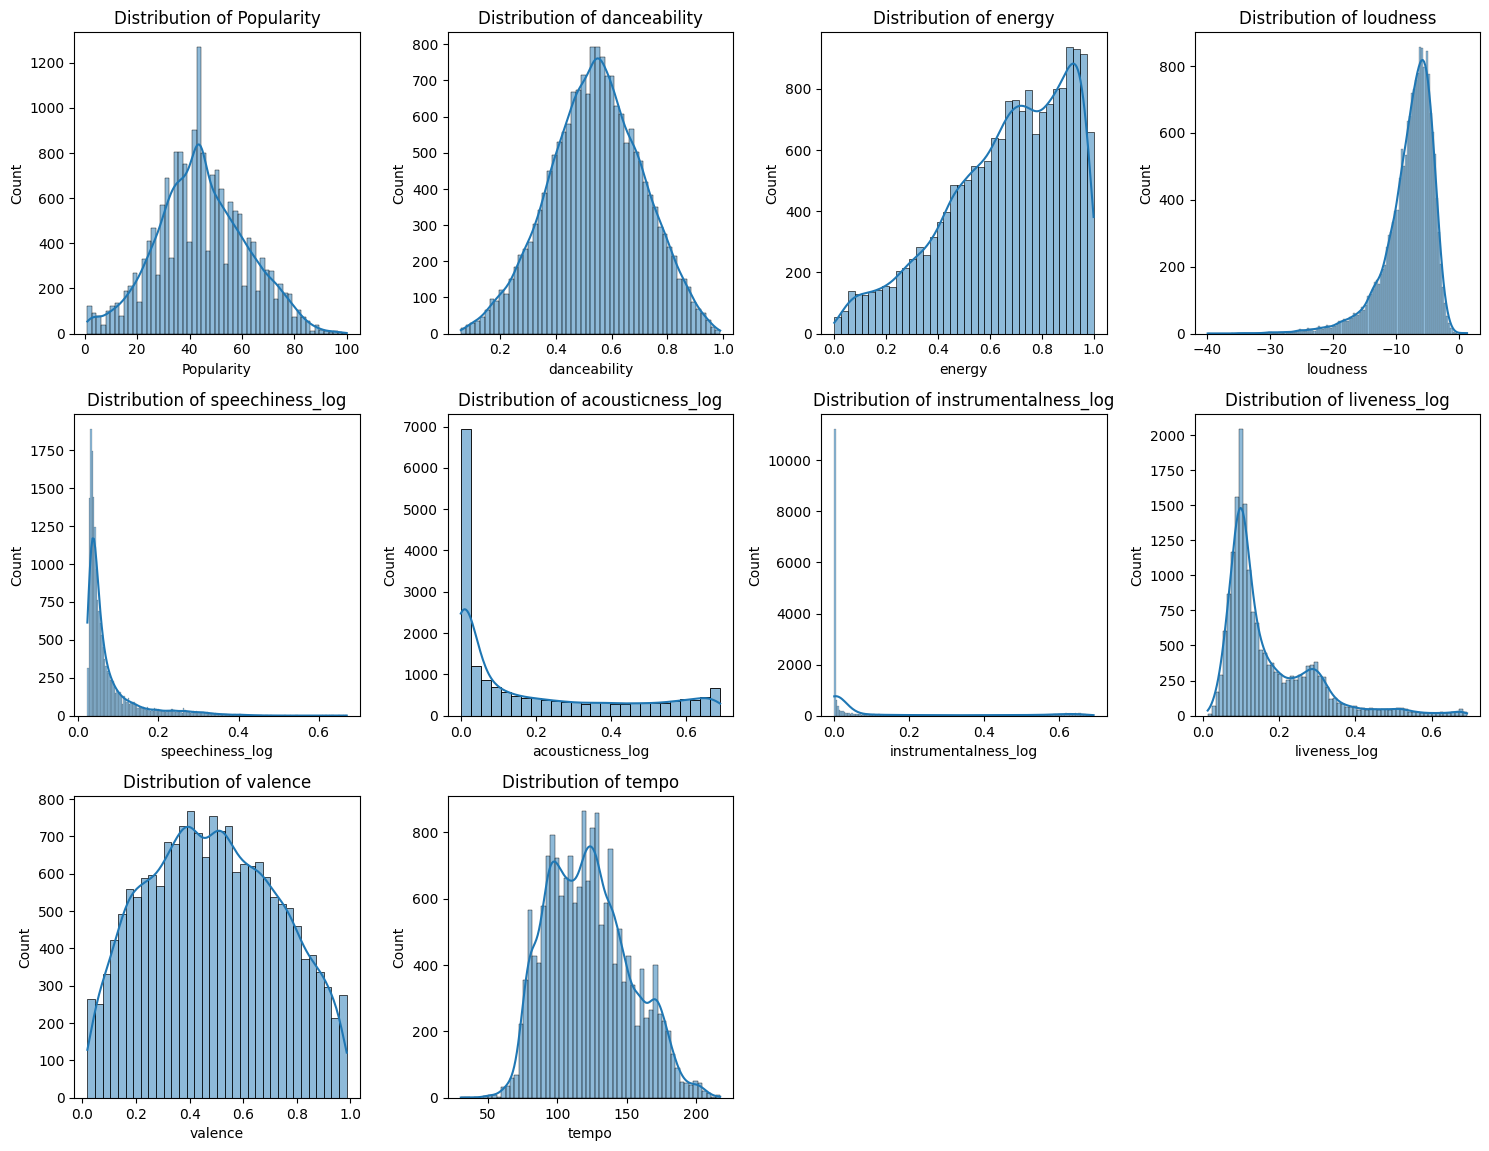

In [7]:
# Identifying features to transform based on their skewness
skewed_features = data_preprocessed[features].apply(lambda x: x.skew()).sort_values(ascending=False)
skewed_features = skewed_features[skewed_features > 1]  # Arbitrary threshold for skewness

# Applying Log-transform to the skewed features
for feature in skewed_features.index:
    data_preprocessed[f'{feature}_log'] = np.log1p(data_preprocessed[feature])  # log1p for log(1+x) to handle zero values

# Updating the names of feature in the list after transformations
features_log_transformed = [f'{feature}_log' if feature in skewed_features.index else feature for feature in features]

# Plotting the distribution of log-transformed features
plt.figure(figsize=(15, 15))
for i, feature in enumerate(features_log_transformed, 1):
    plt.subplot(4, 4, i)
    sns.histplot(data_preprocessed[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


<ipython-input-8-df9b0d7ca224>:29: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(likelihoods), axis=1)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Custom Naive Bayes Classifier Accuracy: 0.43916666666666665
Precision: 0.42371292381515674
Recall: 0.43916666666666665
F1-Score: 0.41279287109644114


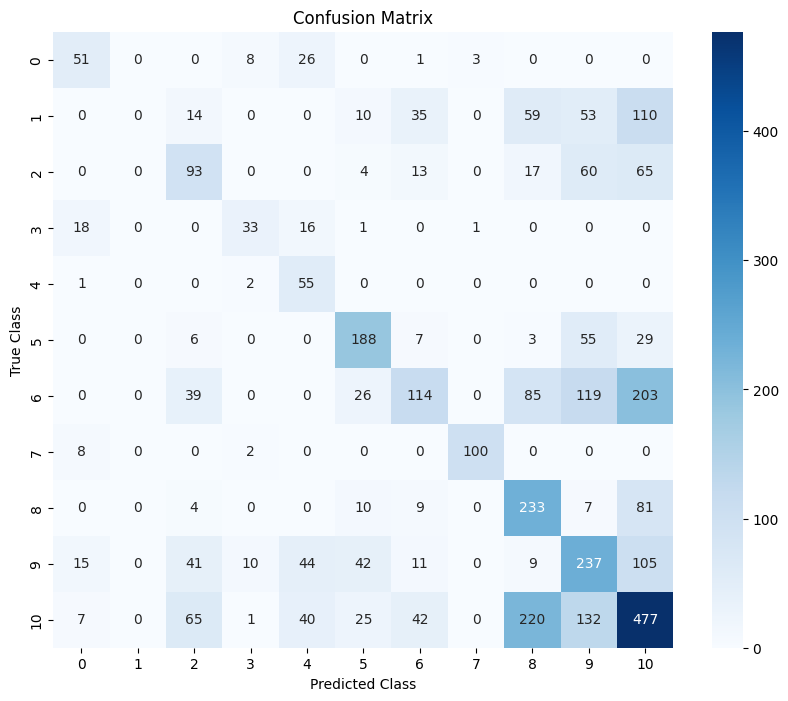

In [8]:
X_raw = data_preprocessed.drop(['Class'], axis=1).values
y_raw = data_preprocessed['Class'].values

# Adding seed for reproduciblity
np.random.seed(42)
indices = np.random.permutation(X_raw.shape[0])
train_idx, test_idx = indices[:int(X_raw.shape[0] * 0.8)], indices[int(X_raw.shape[0] * 0.8):]
X_train, X_test = X_raw[train_idx], X_raw[test_idx]
y_train, y_test = y_raw[train_idx], y_raw[test_idx]

# Computing the prior probability of each class, mean, and variance for each feature per class
unique_classes = np.unique(y_train)
prior_probabilities = np.array([len(y_train[y_train == c]) / len(y_train) for c in unique_classes])
class_feature_means = np.array([X_train[y_train == c].mean(axis=0) for c in unique_classes])
class_feature_variances = np.array([X_train[y_train == c].var(axis=0) for c in unique_classes])

def gaussian_pdf(x, mean, var):
    """Normal Distribution"""
    eps = 1e-6
    coeff = 1 / np.sqrt(2 * np.pi * var + eps)
    exponent = np.exp(-(x - mean)**2 / (2 * var + eps))
    return coeff * exponent

def predict(X, unique_classes, prior_probabilities, class_feature_means, class_feature_variances):
    posteriors = []
    for i, c in enumerate(unique_classes):
        prior = np.log(prior_probabilities[i])
        likelihoods = gaussian_pdf(X, class_feature_means[i], class_feature_variances[i])
        log_likelihood = np.sum(np.log(likelihoods), axis=1)
        posterior = prior + log_likelihood
        posteriors.append(posterior)
    posteriors = np.column_stack(posteriors)
    predictions = np.argmax(posteriors, axis=1)
    return predictions

# Callint the predict function
y_pred_custom = predict(X_test, unique_classes, prior_probabilities, class_feature_means, class_feature_variances)

# Calculating the accuracy
accuracy_custom = np.mean(y_pred_custom == y_test)
print(f"Custom Naive Bayes Classifier Accuracy: {accuracy_custom}")


from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
# Calculating Precision, Recall, and F1-Score using sicikit-learn
precision = precision_score(y_test, y_pred_custom, average='weighted')
recall = recall_score(y_test, y_pred_custom, average='weighted')
f1 = f1_score(y_test, y_pred_custom, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_custom)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show();

